In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scvi.dataset.paul_tusi import Paul,Tusi
from scvi.dataset.dataset import GeneExpressionDataset
import numpy as np
use_cuda = True
from scvi.harmonization.utils_chenling import run_model
from scvi.dataset.dataset import SubsetGenes
from scvi.harmonization.utils_chenling import CompareModels
from scvi.harmonization.utils_chenling import KNNJaccardIndex
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors
import pandas as pd
plotname = 'Continuous'

dataset1 = Paul()
dataset1.subsample_genes(dataset1.nb_genes)
dataset2 = Tusi()
dataset2.time_traj = dataset2.time_traj[dataset2.batch_indices.ravel()==1]


Downsampling from 8716 to 8716 genes
Downsampling from 2730 to 2730 cells


In [4]:
dataset2 = Tusi()
dataset2.time_traj = dataset2.time_traj[dataset2.batch_indices.ravel()==1]
dataset2.diff_axis = dataset2.diff_axis[dataset2.batch_indices.ravel()==1]

In [5]:
dataset2.update_cells(dataset2.batch_indices.ravel()==1)
dataset2.subsample_genes(dataset2.nb_genes)
gene_dataset = GeneExpressionDataset.concat_datasets(dataset1, dataset2)


Downsampling from 4763 to 4016 cells


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Downsampling from 28205 to 24008 genes
Downsampling from 4016 to 4016 cells
Keeping 6883 genes


In [6]:

# CompareModels(gene_dataset, dataset1, dataset2, plotname, 'writedata')

seurat1 = np.genfromtxt('../Seurat_data/' + plotname + '.1.CCA.txt')
seurat2 = np.genfromtxt('../Seurat_data/' + plotname + '.2.CCA.txt')
seurat, batch_indices, labels, keys, stats = run_model('readSeurat', gene_dataset, dataset1, dataset2,
                                                       filename=plotname)


In [7]:
dataset1, dataset2, gene_dataset = SubsetGenes(dataset1, dataset2, gene_dataset, plotname)
vae1, _, _, _, _ = run_model('vae', dataset1, 0, 0, filename=plotname, rep='vae1')
vae2, _, _, _, _ = run_model('vae', dataset2, 0, 0, filename=plotname, rep='vae2')
vae,  _, _, _, _ = run_model('vae', gene_dataset, dataset1, dataset2,filename=plotname, rep='0')


Downsampling from 8716 to 1585 genes
Downsampling from 2730 to 2730 cells


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Downsampling from 24008 to 1585 genes
Downsampling from 4016 to 4016 cells
Downsampling from 6883 to 1585 genes
Downsampling from 6746 to 6746 cells
LL : 601.8697
LL : 643.1225
LL : 624.2923


In [8]:
from scvi.harmonization.utils_chenling import trainSCANVI,trainVAE,SCANVI,SemiSupervisedTrainer,AlternateSemiSupervisedTrainer
vae_posterior = trainVAE(gene_dataset,filename=plotname,rep='0', nlayers=2)

In [9]:
scanvi1 = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi1.load_state_dict(vae_posterior.model.state_dict(), strict=False)
# trainer_scanvi1 = SemiSupervisedTrainer(scanvi1, gene_dataset, classification_ratio=50,
#                                        n_epochs_classifier=1, lr_classification=5 * 1e-3)
trainer_scanvi1 = AlternateSemiSupervisedTrainer(scanvi1, gene_dataset, n_epochs_classifier=100, lr_classification=5 * 1e-3)
trainer_scanvi1.labelled_set = trainer_scanvi1.create_posterior(indices=(gene_dataset.batch_indices == 0))
trainer_scanvi1.unlabelled_set = trainer_scanvi1.create_posterior(indices=(gene_dataset.batch_indices == 1))
trainer_scanvi1.train(n_epochs=10)
full = trainer_scanvi1.create_posterior(trainer_scanvi1.model, gene_dataset, indices=np.arange(len(gene_dataset)))
ll = full.ll(verbose=True)
scanvi1, _, _ = full.sequential().get_latent()

training: 100%|██████████| 10/10 [02:07<00:00, 12.77s/it]
LL : 624.2973


In [10]:
scanvi2 = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi2.load_state_dict(vae_posterior.model.state_dict(), strict=False)
# trainer_scanvi2 = SemiSupervisedTrainer(scanvi2, gene_dataset, classification_ratio=50,
#                                        n_epochs_classifier=1, lr_classification=5 * 1e-3)
trainer_scanvi2 = AlternateSemiSupervisedTrainer(scanvi2, gene_dataset, n_epochs_classifier=100, lr_classification=5 * 1e-3)
trainer_scanvi2.labelled_set = trainer_scanvi2.create_posterior(indices=(gene_dataset.batch_indices == 1))
trainer_scanvi2.unlabelled_set = trainer_scanvi2.create_posterior(indices=(gene_dataset.batch_indices == 0))
trainer_scanvi2.train(n_epochs=10)
full = trainer_scanvi2.create_posterior(trainer_scanvi2.model, gene_dataset, indices=np.arange(len(gene_dataset)))
ll = full.ll(verbose=True)
scanvi2, _, _ = full.sequential().get_latent()

training: 100%|██████████| 10/10 [02:58<00:00, 17.89s/it]
LL : 622.1795


In [11]:
KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])
seurat_seurat = [KNNJaccardIndex(seurat1, seurat2, seurat, batch_indices, k)[0] for k in KNeighbors]
vae_seurat = [KNNJaccardIndex(vae1, vae2, seurat, batch_indices, k)[0] for k in KNeighbors]
vae_vae = [KNNJaccardIndex(vae1, vae2, vae, batch_indices, k)[0] for k in KNeighbors]
seurat_vae = [KNNJaccardIndex(seurat1, seurat2, vae, batch_indices, k)[0] for k in KNeighbors]
vae_scanvi1 = [KNNJaccardIndex(vae1, vae2, scanvi1, batch_indices, k)[0] for k in KNeighbors]
vae_scanvi2 = [KNNJaccardIndex(vae1, vae2, scanvi2, batch_indices, k)[0] for k in KNeighbors]

In [12]:
%matplotlib inline

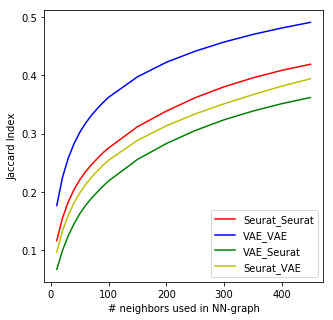

In [13]:
plt.figure(figsize=(5, 5))
plt.plot(KNeighbors, seurat_seurat,'r',label='Seurat_Seurat')
plt.plot(KNeighbors, vae_vae,'b',label='VAE_VAE')
# plt.plot(KNeighbors, vae_scanvi1,'black',label='VAE_SCANVI1')
# plt.plot(KNeighbors, vae_scanvi2,'gray',label='VAE_SCANVI2')
plt.plot(KNeighbors, vae_seurat,'g',label='VAE_Seurat')
plt.plot(KNeighbors, seurat_vae,'y',label='Seurat_VAE')
plt.legend(loc='lower right', shadow=False)
plt.xlabel("# neighbors used in NN-graph")
plt.ylabel("Jaccard Index")
# plt.show()
plt.savefig("figures/continuous_jaccard.pdf", transparency=True)


In [14]:
# plt.figure(figsize=(5, 5))
# plt.plot(KNeighbors, seurat_seurat,'b',label='Seurat(sin) Seurat(har)')
# plt.plot(KNeighbors, vae_vae,'r',label='scVI(sin) scVI(har)')
# plt.plot(KNeighbors, vae_scanvi1,'g',label='scVI(sin) SCANVI(Paul->Tusi)(har)')
# plt.plot(KNeighbors, vae_scanvi2,'g-.',label='scVI(sin) SCANVI(Tusi->Paul)(har)')
# plt.plot(KNeighbors, vae_seurat,'b--',label='Seurat(sin) scVI(har)')
# plt.plot(KNeighbors, seurat_vae,'r--',label='scVI(sin) Seurat(var)')
# plt.legend(loc='lower right', shadow=False)
# plt.xlabel("# neighbors used in NN-graph")
# plt.ylabel("Jaccard Index")
# # plt.show()
# plt.savefig("figures/continuous_jaccard_all.pdf", transparency=True)


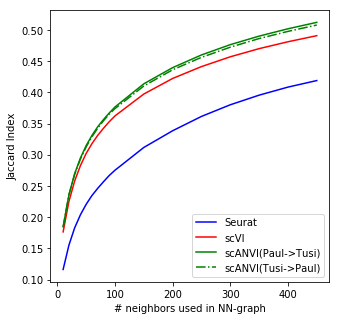

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(KNeighbors, seurat_seurat,'b',label='Seurat')
plt.plot(KNeighbors, vae_vae,'r',label='scVI')
plt.plot(KNeighbors, vae_scanvi1,'g',label='scANVI(Paul->Tusi)')
plt.plot(KNeighbors, vae_scanvi2,'g-.',label='scANVI(Tusi->Paul)')
plt.legend(loc='lower right', shadow=False)
plt.xlabel("# neighbors used in NN-graph")
plt.ylabel("Jaccard Index")
# plt.show()
plt.savefig("figures/continuous_jaccard_all.pdf", transparency=True)


In [16]:
def entropy_from_indices(indices):
    return entropy(np.array(np.unique(indices, return_counts=True)[1].astype(np.int32)))


def entropy_batch_mixing_subsampled(latent, batches, sample, n_neighbors=50, n_pools=50, n_samples_per_pool=100):
    X = latent[sample,:]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(latent)
    indices = nbrs.kneighbors(X, return_distance=False)[:, 1:]
    batch_indices = np.vectorize(lambda i: batches[i])(indices)
    entropies = np.apply_along_axis(entropy_from_indices, axis=1, arr=batch_indices)
    if n_pools == 1:
        res = np.mean(entropies)
    else:
        res = np.mean([
            np.mean(entropies[np.random.choice(len(entropies), size=n_samples_per_pool)])
            for _ in range(n_pools)
        ])
    return res

import pandas as pd

In [17]:
dataset2.time_traj.shape, dataset2.diff_axis.shape

((4016,), (4016,))

In [18]:
import pandas as pd
probs = np.sign(dataset2.diff_axis) * np.exp(-dataset2.time_traj)
fac = pd.qcut(probs, 20, retbins=False, duplicates="drop")
intervals, bin = np.unique(np.asarray(fac),return_inverse=True)
midint = [(x.left+x.right)/2 for x in intervals]

BE_vae=[]
for i in np.unique(bin):
    sample = np.arange(len(batch_indices))[batch_indices==1][bin==i]
    BE_vae.append(entropy_batch_mixing_subsampled(vae,batch_indices,sample))

BE_seurat=[]
for i in np.unique(bin):
    sample = np.arange(len(batch_indices))[batch_indices==1][bin==i]
    BE_seurat.append(entropy_batch_mixing_subsampled(seurat,batch_indices,sample))
    
BE_scanvi1=[]
for i in np.unique(bin):
    sample = np.arange(len(batch_indices))[batch_indices==1][bin==i]
    BE_scanvi1.append(entropy_batch_mixing_subsampled(scanvi1,batch_indices,sample))

BE_scanvi2=[]
for i in np.unique(bin):
    sample = np.arange(len(batch_indices))[batch_indices==1][bin==i]
    BE_scanvi2.append(entropy_batch_mixing_subsampled(scanvi2,batch_indices,sample))


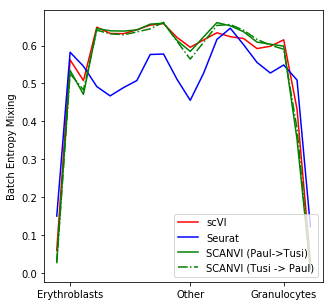

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(np.arange(20), BE_vae,'r',label='scVI')
plt.plot(np.arange(20), BE_seurat,'b',label='Seurat')
plt.plot(np.arange(20), BE_scanvi1,'g',label='SCANVI (Paul->Tusi)')
plt.plot(np.arange(20), BE_scanvi2,'g-.',label='SCANVI (Tusi -> Paul)')
plt.legend(loc='lower right', shadow=False)
plt.xticks([1, 10, 17], ['Erythroblasts', 'Other', 'Granulocytes'])
plt.ylabel("Batch Entropy Mixing")
plt.savefig("figures/continuous_batch_all_entropy.pdf", transparency=True)

In [20]:
gene_dataset.cell_types

array(['Ery0', 'MegaK', 'Ly', 'Ba', 'Neu0', 'G', 'Ery3', 'Mono2', 'M',
       'Eos', 'Mono0', 'Mono1', 'E', 'D', 'Neu2', 'Meg', 'DC', 'Ery5',
       'Baso2', 'Baso1', 'Ery2', 'Ery4', 'Ery1', 'C19', 'Ery6', 'Neu1'],
      dtype='<U5')

In [21]:
# new_keys = np.asarray(['Neu1', 'Megakaryocyte','Granulocyte', 'Baso2', 'Neu1', 'Basophil','Erythrocyte','Ery6',
#                        'Baso1','Ery3', 'Ery4', 'Ery5', 'Eosinophil', 'Mono1','Lymphocyte','Mono2',
#                        'C19', 'Meg1', 'Dendritic Cells','Monocyte', 'Ery2', 'Mono1','Neu2','Ery1','Den1','Ery2'])

new_keys = gene_dataset.cell_types
key_order = np.argsort(new_keys)


In [22]:
for i,k in enumerate(key_order):
    if new_keys[k] not in ["Basophil", "Dendritic Cells", "Erythrocyte", "Granulocyte", "Lymphocyte", "Monocyte", "Megakaryocyte"]:
        print(new_keys[k])

Ba
Baso1
Baso2
C19
D
DC
E
Eos
Ery0
Ery1
Ery2
Ery3
Ery4
Ery5
Ery6
G
Ly
M
Meg
MegaK
Mono0
Mono1
Mono2
Neu0
Neu1
Neu2


In [23]:
new_keys[key_order]

array(['Ba', 'Baso1', 'Baso2', 'C19', 'D', 'DC', 'E', 'Eos', 'Ery0',
       'Ery1', 'Ery2', 'Ery3', 'Ery4', 'Ery5', 'Ery6', 'G', 'Ly', 'M',
       'Meg', 'MegaK', 'Mono0', 'Mono1', 'Mono2', 'Neu0', 'Neu1', 'Neu2'],
      dtype='<U5')

In [24]:
import seaborn as sns
c1 = ['green',#Basophil
      'blue', #Dendritic
      'red', #Erythro
      'slateblue',#granulocyte
      'cyan',#Ly
      'yellow',#Megakaryo
      'orange'] #Monocyte

c2 = sns.color_palette('Greens',2) + \
sns.color_palette('Greys',1) + \
sns.color_palette('Blues_d',1) + \
sns.color_palette('Blues',1) + \
sns.color_palette('Reds_d',7) + \
sns.light_palette('yellow',1,reverse=True)+ \
sns.color_palette('Oranges',3) +\
sns.color_palette('Purples_d',3) 

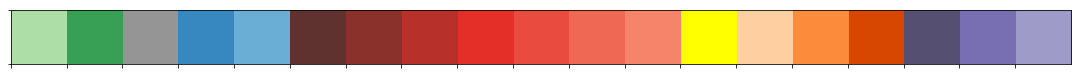

In [25]:
sns.palplot(c2)

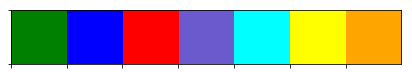

In [26]:
sns.palplot(c1)

In [27]:
from umap import UMAP
latent_u = UMAP(spread=2).fit_transform(vae)

In [28]:
# plot TUSI
batch_indices.shape, latent_u.shape, labels.shape, keys

((6746,),
 (6746, 2),
 (6746,),
 array(['Ery0', 'MegaK', 'Ly', 'Ba', 'Neu0', 'G', 'Ery3', 'Mono2', 'M',
        'Eos', 'Mono0', 'Mono1', 'E', 'D', 'Neu2', 'Meg', 'DC', 'Ery5',
        'Baso2', 'Baso1', 'Ery2', 'Ery4', 'Ery1', 'C19', 'Ery6', 'Neu1'],
       dtype='<U5'))

No handles with labels found to put in legend.


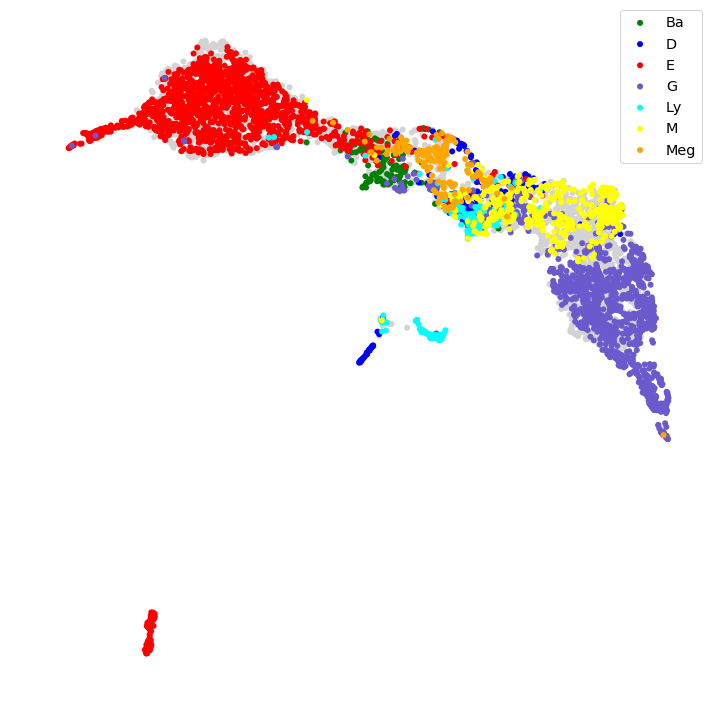

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_u[batch_indices!=1, 0], latent_u[batch_indices!=1, 1], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], c=c1[j-1], label=new_keys[k],
                   edgecolors='none')
        ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/continuous_Tusi.pdf", transparency=True)

No handles with labels found to put in legend.


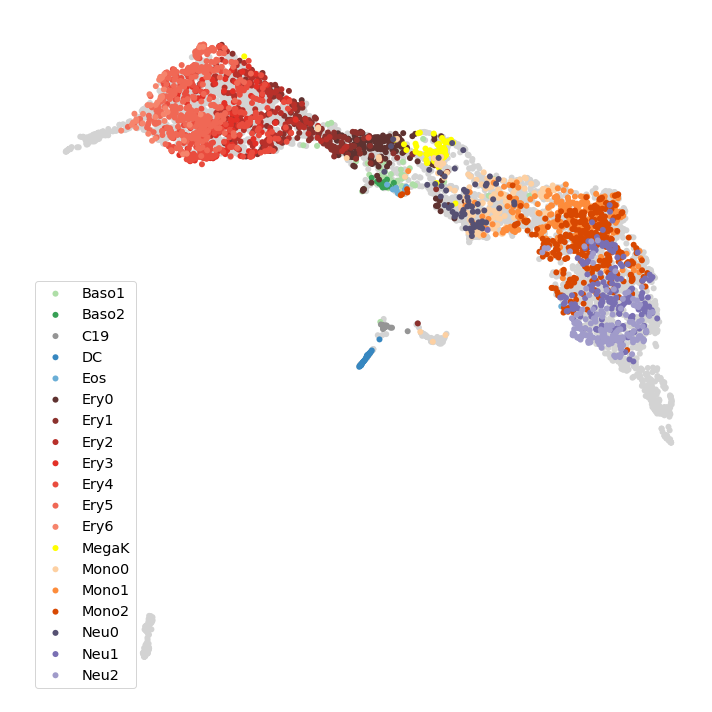

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_u[batch_indices!=0, 0], latent_u[batch_indices!=0, 1], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] not in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], c=c2[j-1], label=new_keys[k],
                   edgecolors='none')
        ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/continuous_Paul.pdf", transparency=True)

In [31]:
from umap import UMAP
latent_s = UMAP(spread=2).fit_transform(seurat)

No handles with labels found to put in legend.


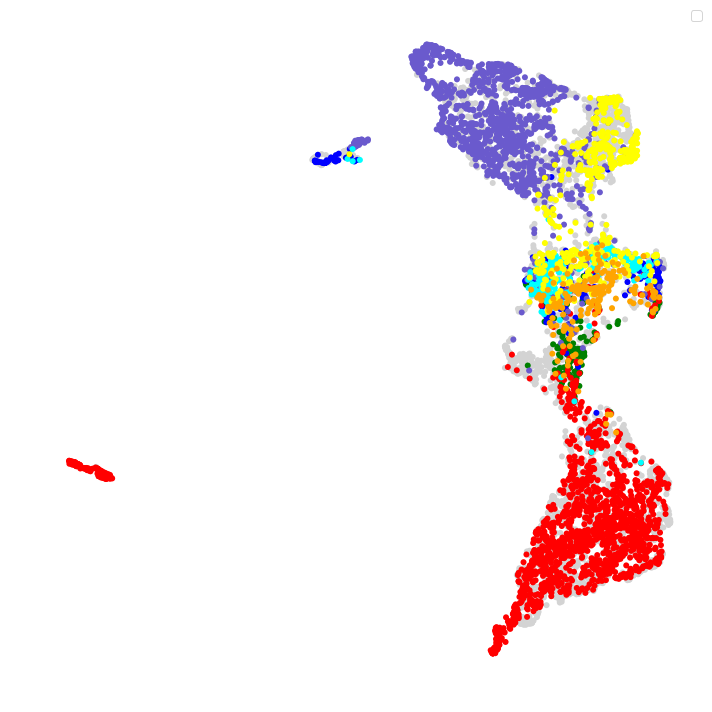

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_s[batch_indices!=1, 1], -latent_s[batch_indices!=1, 0], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_s[labels == k, 1], -latent_s[labels == k, 0], c=c1[j-1], label=new_keys[k],
                   edgecolors='none')
#         ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/continuous_seurat_Tusi.pdf", transparency=True)

No handles with labels found to put in legend.


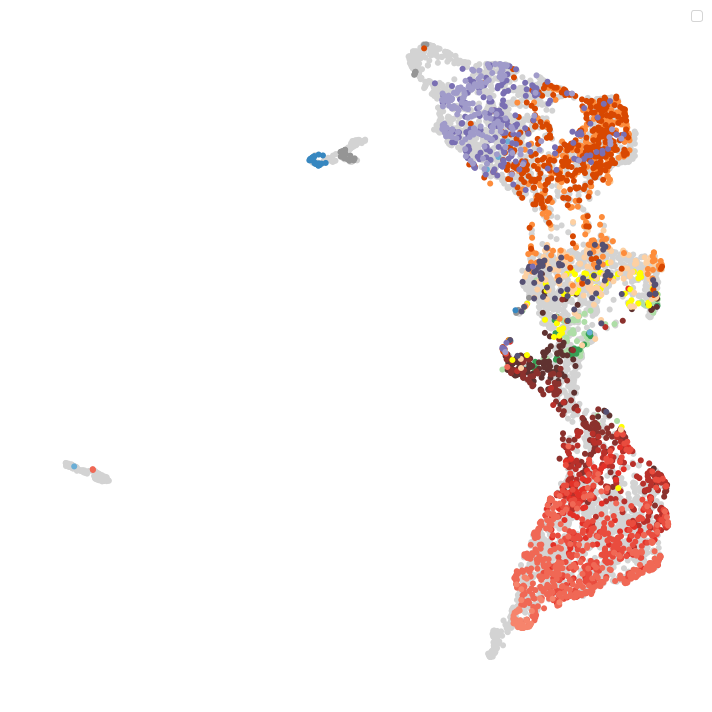

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_s[batch_indices!=0, 1], -latent_s[batch_indices!=0, 0], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] not in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_s[labels == k, 1], -latent_s[labels == k, 0], c=c2[j-1], label=new_keys[k],
                   edgecolors='none')
#         ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/continuous_seurat_Paul.pdf", transparency=True)

In [34]:
from umap import UMAP
latent_s = UMAP(spread=2).fit_transform(scanvi1)

No handles with labels found to put in legend.


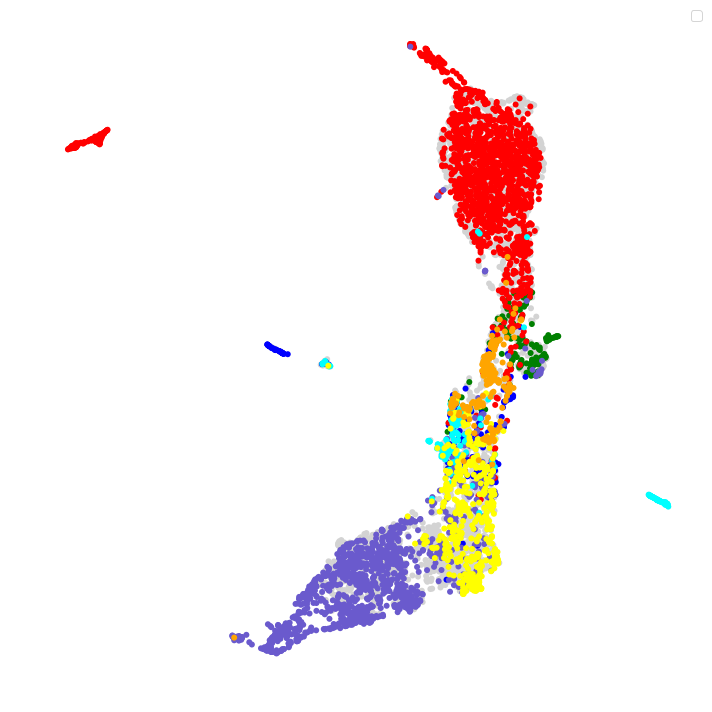

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_s[batch_indices!=1, 1], -latent_s[batch_indices!=1, 0], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_s[labels == k, 1], -latent_s[labels == k, 0], c=c1[j-1], label=new_keys[k],
                   edgecolors='none')
#         ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
plt.tight_layout()
# plt.show()
plt.savefig("figures/continuous_scanvi1_Tusi.pdf", transparency=True)

No handles with labels found to put in legend.


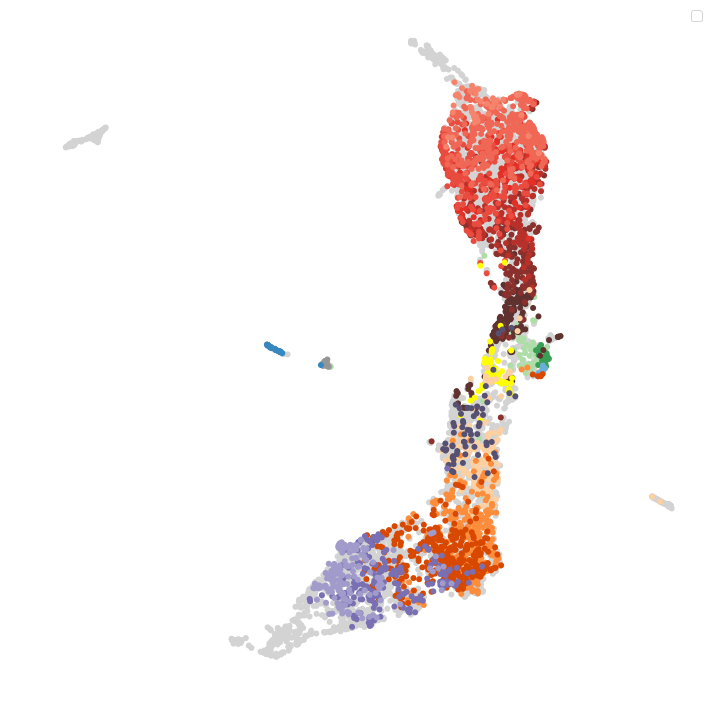

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_s[batch_indices!=0, 1], -latent_s[batch_indices!=0, 0], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] not in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_s[labels == k, 1], -latent_s[labels == k, 0], c=c2[j-1], label=new_keys[k],
                   edgecolors='none')
#         ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/continuous_scanvi1_Paul.pdf", transparency=True)

In [37]:
latent_s = UMAP(spread=2).fit_transform(scanvi2)

No handles with labels found to put in legend.


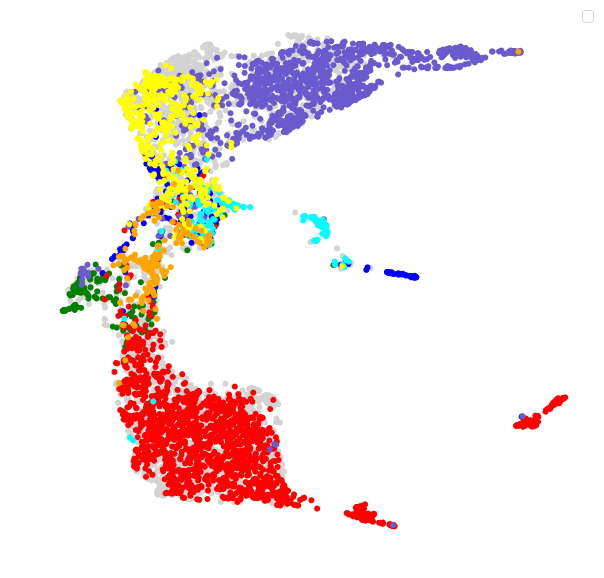

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_s[batch_indices!=1, 1], -latent_s[batch_indices!=1, 0], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_s[labels == k, 1], -latent_s[labels == k, 0], c=c1[j-1], label=new_keys[k],
                   edgecolors='none')
#         ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
# plt.tight_layout()
plt.savefig("figures/continuous_scanvi2_Tusi.pdf", transparency=True)

No handles with labels found to put in legend.


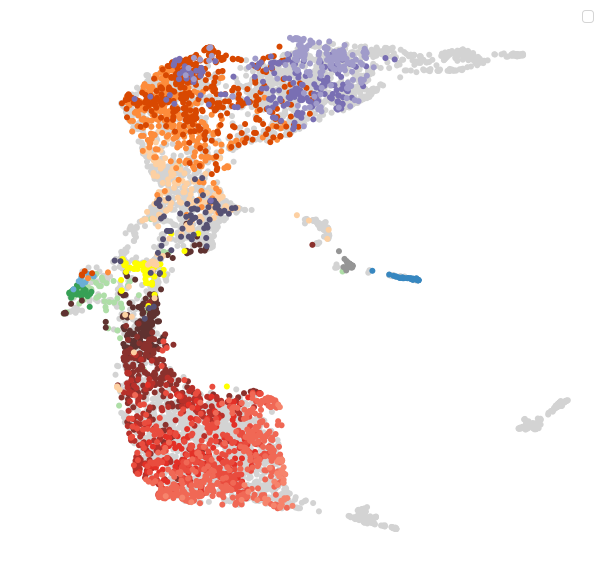

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(latent_s[batch_indices!=0, 1], -latent_s[batch_indices!=0, 0], c='lightgrey',
        edgecolors='none')
ax.legend(borderaxespad=0, fontsize='x-large')
j = 0
for i,k in enumerate(key_order):
    if keys[k] not in ["Ba", "D", "E", "G", "Ly", "M", "Meg"]:
        j += 1
        ax.scatter(latent_s[labels == k, 1], -latent_s[labels == k, 0], c=c2[j-1], label=new_keys[k],
                   edgecolors='none')
#         ax.legend( borderaxespad=0, fontsize='x-large')
plt.axis("off")
# plt.tight_layout()
plt.savefig("figures/continuous_scanvi2_Paul.pdf", transparency=True)

In [40]:
# markers = ['GATA1','GATA2','FLT3','IRF8','ITGAM','S100A8','HBA-A2','ALAS2']
markers = ['ITGAM','S100A8','HBA-A2','ALAS2']
gexp = []
for x in markers:
    gexp.append(np.asarray(gene_dataset.X[:,gene_dataset.gene_names==x].todense().squeeze()))

[array([[0., 0., 0., ..., 0., 0., 0.]]), array([[ 0.,  0.,  0., ..., 14.,  0.,  0.]]), array([[0., 0., 1., ..., 1., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.]])]


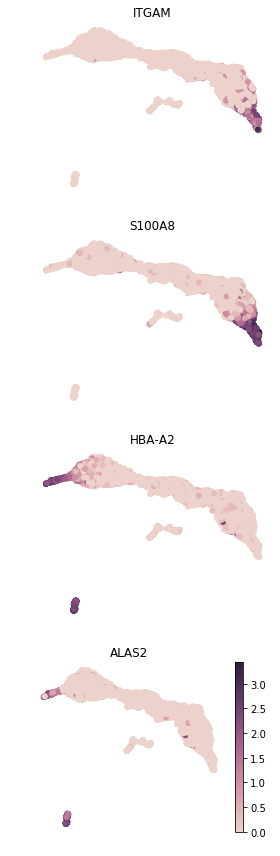

In [41]:
print(gexp)
import seaborn as sns
plt.figure(figsize=(4, 12), facecolor='w', edgecolor='k')
for i,marker in enumerate(gexp):
    plt.subplot(4, 1, i+1)
    plt.scatter(latent_u[:, 0], latent_u[:, 1], c=np.log(1+marker.ravel()),
                cmap = sns.cubehelix_palette(as_cmap=True),edgecolors='none')
    plt.axis("off")
    plt.tight_layout()
    plt.title(markers[i])
plt.colorbar()
plt.savefig("figures/continuous_marker_genes.pdf", transparency=True)